In [1]:
import numpy as np
from quam_libs.components import QuAM, TransmonPair
from quam_libs.experiments.two_qubit_xeb import (
    XEBConfig,
    XEB,
    backend as fake_backend,
    QUAGate,
)

machine = QuAM.load()
qubits = machine.active_qubits
# Get the relevant QuAM components
target_qubit_indices = [4]  # Indices of the target qubits
target_qubits = [qubits[i] for i in target_qubit_indices]
target_qubit_pairs = [
    qubit_pair
    for qubit_pair in machine.active_qubit_pairs
    if qubit_pair.qubit_control in target_qubits and qubit_pair.qubit_target in target_qubits
]

print("target_qubits: %s" %[q.name for q in target_qubits]) 


def cz_gate(qubit_pair: TransmonPair):
    """
    CZ gate QUA macro: Add your own QUA code here implementing your CZ gate for any given qubit pair
    :param qubit_pair: TransmonPair instance on which to apply the gate
    :return: None
    """

    pass


cz_qua = QUAGate("cz", cz_gate)

xeb_config = XEBConfig(
    seqs=17, #81,
    # depths=np.arange(1, 1200, 24),
    depths=np.arange(1, 28, 1),
    n_shots=700, #1000,
    readout_qubits=qubits, 
    qubits=target_qubits,
    qubit_pairs=target_qubit_pairs,
    baseline_gate_name="x90",
    gate_set_choice="sw",
    two_qb_gate=None, #cz_qua,
    save_dir="",
    should_save_data=False, #True,
    generate_new_data=True,
    disjoint_processing=False, #False,
    # reset_method="active",
    # reset_kwargs={"max_tries": 3, "pi_pulse": "x180"},
    reset_method="cooldown", #"active",
    reset_kwargs={"cooldown_time": 100000, "max_tries": 3, "pi_pulse": "x180"},
)

simulate = False  # Set to True to simulate the experiment with Qiskit Aer instead of running it on the QPU
xeb = XEB(xeb_config, quam=machine)
if simulate:
    job = xeb.simulate(backend=fake_backend)
else:
    job = xeb.run(simulate=False)  # If simulate is False, job is run on the QPU, else pulse output is simulated

# 87 * 500/12 * 1000 = 13m 26.8s 
# 87 * 1200/24 * 700 = 22m 42.3s


2024-10-23 11:44:35,583 - qm - INFO     - Starting session: 6cff354b-452c-4c1b-afae-eb93bac3b168


/Users/adamachuck/anaconda3/envs/QPX/lib/python3.10/site-packages/quam/core/quam_classes.py:475: UserWarning: No QuamRoot initialized, cannot retrieve reference #/ports/analog_outputs/con1/2/5 from FluxLine
  warnings.warn(
/Users/adamachuck/anaconda3/envs/QPX/lib/python3.10/site-packages/quam/core/quam_classes.py:475: UserWarning: No QuamRoot initialized, cannot retrieve reference #/ports/analog_outputs/con1/3/6 from FluxLine
  warnings.warn(
/Users/adamachuck/anaconda3/envs/QPX/lib/python3.10/site-packages/quam/core/quam_classes.py:475: UserWarning: No QuamRoot initialized, cannot retrieve reference #/ports/analog_outputs/con1/3/7 from FluxLine
  warnings.warn(
/Users/adamachuck/anaconda3/envs/QPX/lib/python3.10/site-packages/quam/core/quam_classes.py:475: UserWarning: No QuamRoot initialized, cannot retrieve reference #/ports/analog_outputs/con1/3/8 from FluxLine
  warnings.warn(
/Users/adamachuck/anaconda3/envs/QPX/lib/python3.10/site-packages/quam/core/quam_classes.py:475: UserWar

target_qubits: ['q5']
ge_thresholds[0]: 3.37308134926291e-05
2024-10-23 11:44:40,529 - qm - INFO     - Performing health check
2024-10-23 11:44:40,549 - qm - INFO     - Cluster healthcheck completed successfully.
2024-10-23 11:44:52,775 - qm - INFO     - Adding program to queue.


In [ ]:
job.circuits[7][0].draw("mpl") # job.circuits[seq][depth] 

In [ ]:
job.circuits[7][9].draw("mpl") # job.circuits[seq][depth]

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:671: RuntimeWarning: divide by zero encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:671: RuntimeWarning: invalid value encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)


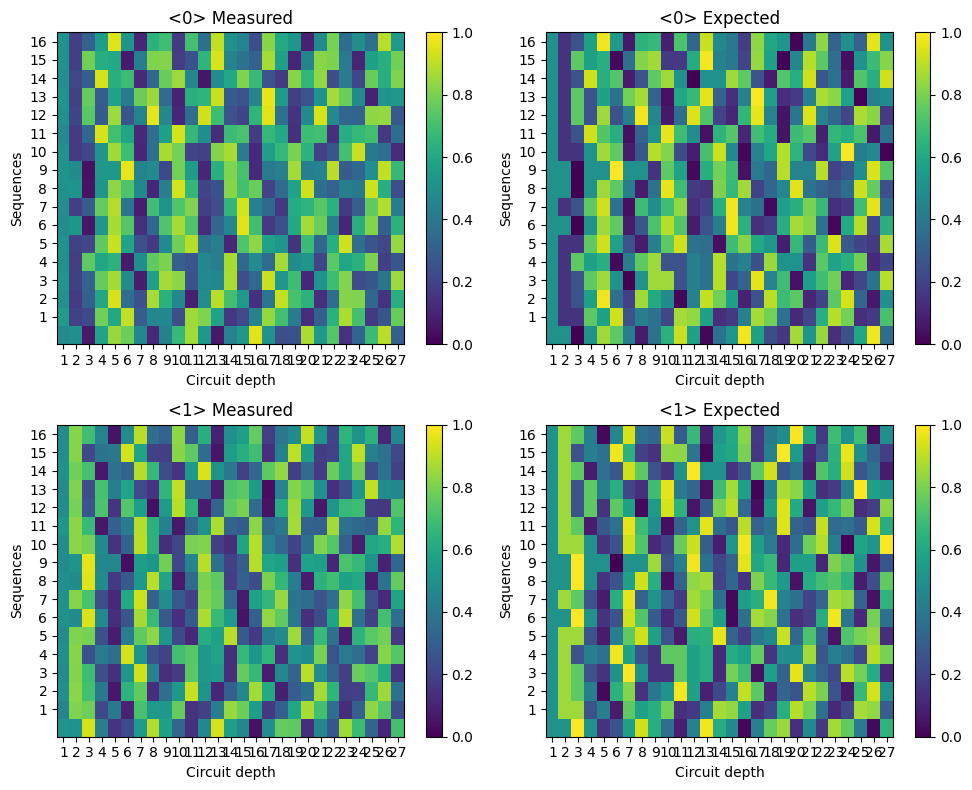

In [13]:
# 1. Extracting Outputs from QPU (QUA, Measured) 
# 2. Extracting recorded Circuits and perform ideal simulation accordingly on CPU (Expected): 
result = job.result()
result.plot_state_heatmap()

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:854: RuntimeWarning: Mean of empty slice
  Fxeb = np.nanmean(self.log_fidelities, axis=0)


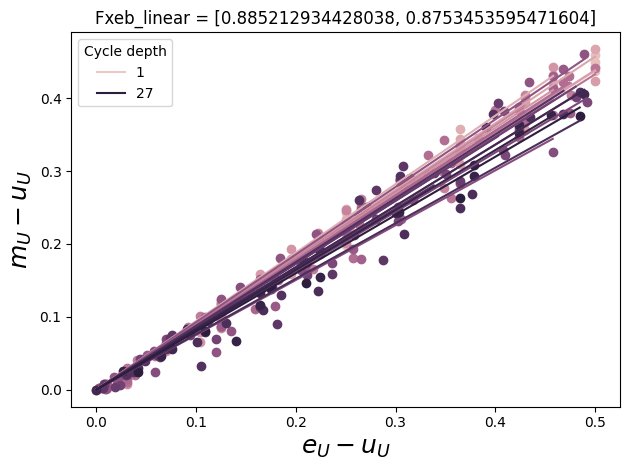

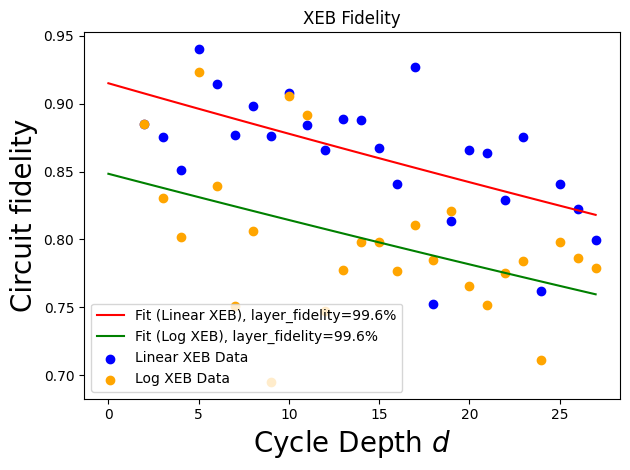

In [14]:
# Compute Fidelities:  
result.plot_records()
result.plot_fidelities()

In [11]:
# Debugging:  
print(xeb.xeb_config.qubit_pairs)
print(result.saved_data['counts']['0']+result.saved_data['counts']['1'])

[]
[[700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 700 700 700 700 700]
 [700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
  700 700 700 700 7